In [ ]:
#@title Common Imports { display-mode: "form" }
!pip install catboost
!pip install optuna
!pip install 'lightgbm==3.0.0'
!pip install pytorch_tabnet
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer

from catboost import CatBoostRegressor
import catboost as cb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn import preprocessing, impute
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import optuna
import lightgbm as lgb
from optuna.integration import lightgbm as opt_lgb
from sklearn.model_selection import StratifiedKFold, PredefinedSplit, train_test_split
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#@title  Read Data { display-mode: "form" }
drive.mount('/content/drive/')
path = '/content/drive/Shareddrives/DA224-O/mp_2/data/train.csv'
df = pd.read_csv(path)
print(df.head())
path2 = '/content/drive/Shareddrives/DA224-O/mp_2/data/test.csv'
df_test = pd.read_csv(path2)

In [ ]:
#@title Data Information { display-mode: "form" }
df.info()

In [ ]:
#@title Describe data { display-mode: "form" }
df.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,30000.000000,26933.000000,26976.000000,27033.000000,27065.000000,27034.000000,26926.000000,26978.000000,27023.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000
mean,14999.500000,193309.698660,0.277219,0.571056,0.683746,0.036184,5.044752,0.198926,-7.418965,0.321167,0.093773,116.557754,3.393967,0.581015,0.36440
std,8660.398374,45713.675116,0.298704,0.189676,0.213314,0.149116,3.379665,0.151879,3.892481,0.466932,0.083474,26.188606,0.525198,0.237429,0.48127
min,0.000000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-30.170399,0.000000,0.015065,63.478876,2.000000,0.013398,0.00000
25%,7499.750000,166492.000000,0.039530,0.425141,0.538968,0.000952,2.000000,0.111956,-9.586576,0.000000,0.038421,97.000171,3.000000,0.398907,0.00000
50%,14999.500000,186908.000000,0.140486,0.607879,0.705028,0.001967,6.000000,0.136253,-6.356886,0.000000,0.055611,113.795116,3.000000,0.599059,0.00000
75%,22499.250000,215039.000000,0.484065,0.718443,0.870518,0.003226,8.000000,0.213505,-4.618818,1.000000,0.117877,128.497863,4.000000,0.760160,1.00000
max,29999.000000,470577.000000,1.065284,0.957131,1.033434,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,218.637439,5.000000,1.022283,1.00000


In [ ]:
#@title Data Shape { display-mode: "form" }
df.shape

(30000, 15)

In [ ]:
#@title Data type conversion, feature drop for EDA { display-mode: "form" }
#Datatype conversion
df.drop(columns=['id'], axis=1, inplace=True) #cannot convert in to categorical if we have Nan Values
mainDF = df.copy()
#df = df.apply(lambda x: x.fillna(x.value_counts().index[0])) #filling with most frequently occuring category
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

df['key'] = df.key.astype('category')
df['audio_mode'] = df.audio_mode.astype('category')
df['time_signature'] = pd.Categorical(df.time_signature)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   song_duration_ms  30000 non-null  float64 
 1   acousticness      30000 non-null  float64 
 2   danceability      30000 non-null  float64 
 3   energy            30000 non-null  float64 
 4   instrumentalness  30000 non-null  float64 
 5   key               30000 non-null  category
 6   liveness          30000 non-null  float64 
 7   loudness          30000 non-null  float64 
 8   audio_mode        30000 non-null  category
 9   speechiness       30000 non-null  float64 
 10  tempo             30000 non-null  float64 
 11  time_signature    30000 non-null  category
 12  audio_valence     30000 non-null  float64 
 13  song_popularity   30000 non-null  int64   
dtypes: category(3), float64(10), int64(1)
memory usage: 2.6 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f757e7c59d0>,
      dtype=object)

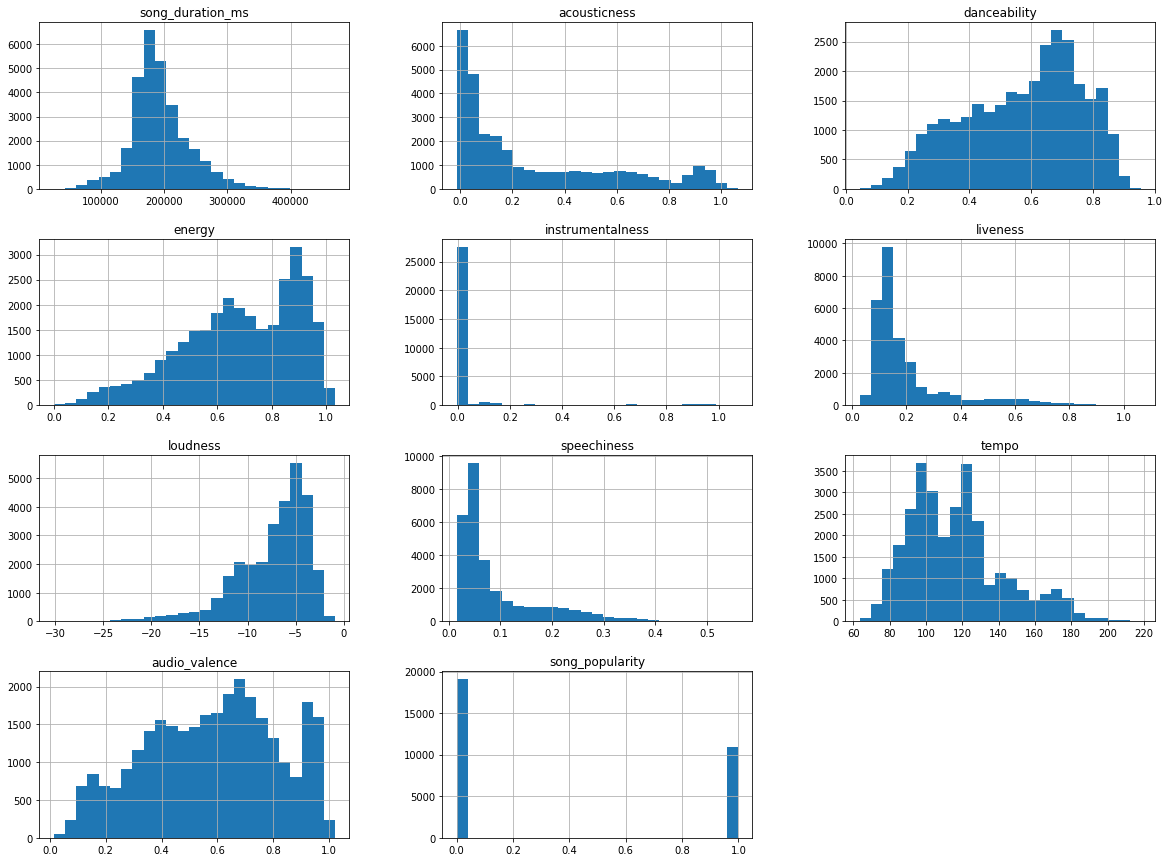

In [ ]:
#@title Data Histogram { display-mode: "form" }
df.hist(bins=25,figsize=(20,15))

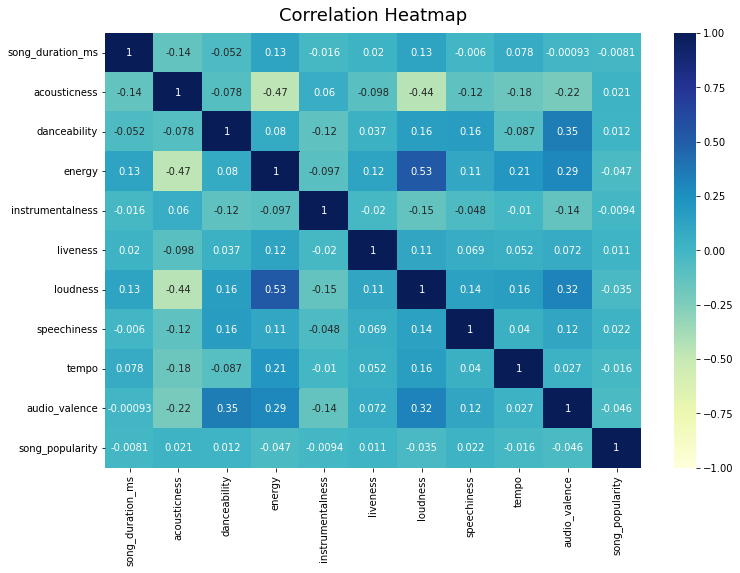

In [ ]:
#@title Correlation heat map { display-mode: "form" }
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="YlGnBu", annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

From above graph we can see energy is highly positively correlated with loudness and negatively correlated with acousticness, danceability is correlated with audio valence, audio valence is correlated with both danceability and loudness

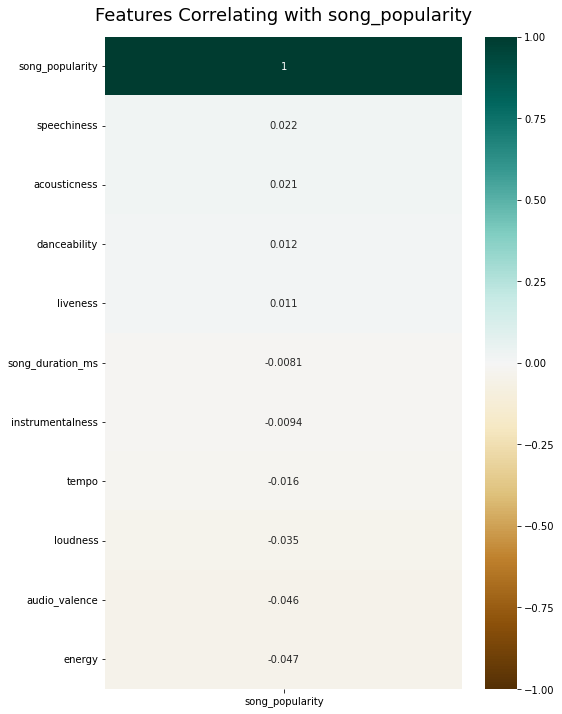

In [ ]:
#@title Features correlation with target song popularity { display-mode: "form" }
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['song_popularity']].sort_values(by='song_popularity', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with song_popularity', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapSong.png', dpi=300, bbox_inches='tight')

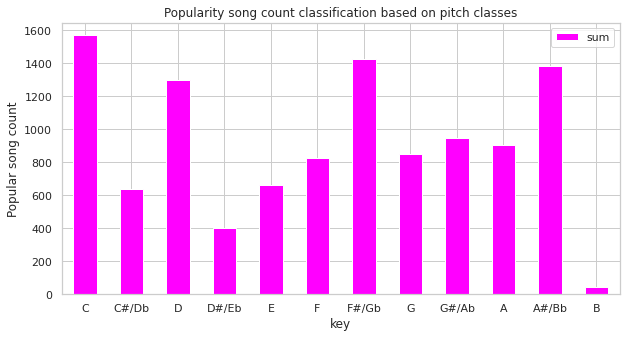

In [ ]:
#@title Below Bar graph shows  songs popularity dependency on pitch class { display-mode: "form" }
keybar = df.groupby(['key'])["song_popularity"].agg(['sum'])
keybar.plot.bar(y='sum', color='magenta', figsize=(10, 5), rot=0)
sns.set_theme(style="whitegrid")
# sns.barplot(x="key", y="sum", data=month)
plt.ylabel("Popular song count")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B'])
plt.title("Popularity song count classification based on pitch classes")
plt.legend(loc='upper right')
plt.savefig('pitch_classify.png', dpi=300, bbox_inches='tight')

From above graph we can see C, D, F#/Gb, A#/Bb has maximum popular songs

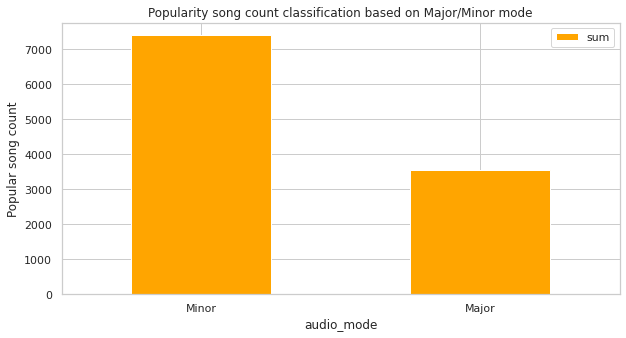

In [ ]:
#@title Below bar graph shows  song popularity dependency on audio mode { display-mode: "form" }
modebar = df.groupby(['audio_mode'])["song_popularity"].agg(['sum'])
modebar.plot.bar(y='sum', color='orange', figsize=(10, 5), rot=0)
sns.set_theme(style="whitegrid")
# sns.barplot(x="key", y="sum", data=month)
plt.ylabel("Popular song count")
plt.xticks([0, 1], ['Minor', 'Major'])
plt.title("Popularity song count classification based on Major/Minor mode")
plt.legend(loc='upper right')
plt.savefig('mode_classify.png', dpi=300, bbox_inches='tight')

From above graph we can see that songs in minor audio mode are more popular than songs in major audio mode

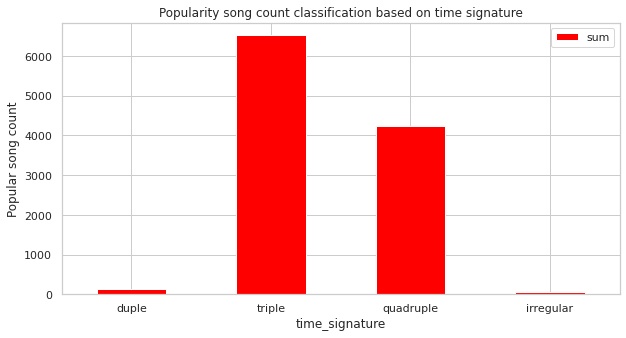

In [ ]:
#@title Below bar graph shows song popularity dependency on time signature { display-mode: "form" }
timesignbar = df.groupby(['time_signature'])["song_popularity"].agg(['sum'])
timesignbar.plot.bar(y='sum', color='red', figsize=(10, 5), rot=0)
sns.set_theme(style="whitegrid")
# sns.barplot(x="key", y="sum", data=month)
plt.ylabel("Popular song count")
plt.xticks([0, 1, 2, 3], ['duple', 'triple', 'quadruple', 'irregular'])
plt.title("Popularity song count classification based on time signature")
plt.legend(loc='upper right')
plt.savefig('timesign_classify.png', dpi=300, bbox_inches='tight')

Triple, quadruple time signature has more popular songs, duple, irregular has very less popular songs

In [ ]:
#@title Detect multicollinearity using variance inflation factor { display-mode: "form" }
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores
df1 = df.iloc[:,:-1]
vif_scores(df1)

,Independent Features,VIF Scores
0,song_duration_ms,16.478231
1,acousticness,2.443647
2,danceability,10.911900
3,energy,16.501961
4,instrumentalness,1.097361
5,key,3.387602
6,liveness,2.763560
7,loudness,5.806481
8,audio_mode,1.481822
9,speechiness,2.377129


In [ ]:
#@title Stratified sampling function based on acousticness { display-mode: "form" }
#stratified sampling with acousticness
def stratified_sampling(df):
  acc_data = df.copy()
  acc_data["acc_cat"] = pd.cut(acc_data["acousticness"],bins=[-1.0, 0.2, 0.4, 0.6, 0.8, 2.0], labels=[1,2,3,4,5]) #when min was given as 0, issue, 0 was classified as Nan
  df_train_strat, df_test_strat = train_test_split(acc_data, test_size=0.2, random_state=42, stratify=acc_data["acc_cat"])
  df_train_strat.drop("acc_cat", axis=1, inplace=True) # income_cat was created for stratified split. Its use is over. Let us remove it.
  df_test_strat.drop("acc_cat", axis=1, inplace=True)
  return df_train_strat, df_test_strat

Eigenvalues:
[2.65518635 1.36700936 1.04416533 1.00792017 0.98917292 0.95699622
 0.93074275 0.91190546 0.90052928 0.84115965 0.78848678 0.59906101
 0.55345284 0.45479524]

Variances (Percentage):
[18.96482656  9.7639457   7.45801299  7.19912979  7.06522649  6.83540247
  6.64788549  6.513339    6.43208396  6.00803286  5.63181378  4.27882894
  3.95306986  3.2484021 ]



Text(0, 0.5, 'Explained variance (%)')

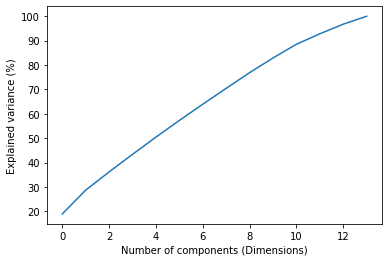

In [ ]:
#@title Experiment Using PCA  { display-mode: "form" }
df_train_strat, df_test_strat = stratified_sampling(df)
songdata = df_train_strat.copy()
songtest = df_test_strat.copy()
#test with PCA
numerical_col=['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']
sc = StandardScaler()
songdata_scaled = sc.fit_transform(songdata)
pca = PCA(n_components=None)
pca.fit(songdata_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")  

We can see from above graph, all components play a vital role, though we have some multi collinearity in data set, we don't need to think that it would affect prediction and hence PCA is not needed for this data set.

          0         1         2         3         4         5         6
0 -1.498086 -2.060766  2.253236  0.852410 -0.308465  1.177783  0.196069
1 -1.935637 -0.955168  1.326517 -1.412435 -0.590457 -0.605091  1.401026
2  0.095035  1.636031  0.749789 -0.108135 -1.245151 -0.237512 -0.342180
3 -0.903649 -0.052102  3.703418 -0.699530  0.427175  0.883574 -2.074655
4 -0.524906  2.019114 -1.315646 -1.371871 -0.950683  0.732751  0.873608

Size: 
(24000, 7)


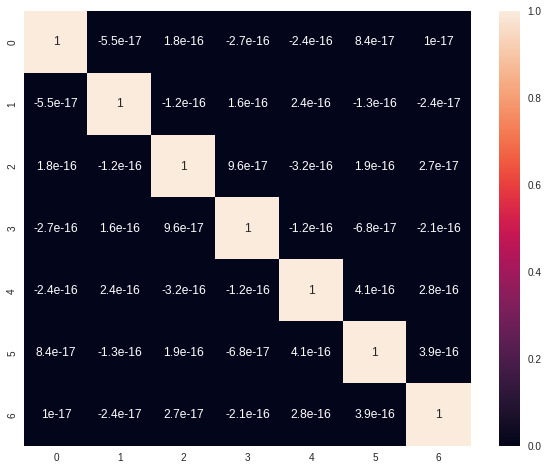

In [ ]:
#@title Plot PCA correlation matrix with components=7 { display-mode: "form" }
sc = StandardScaler()
songdata_scaled = sc.fit_transform(songdata)
pca = PCA(n_components=7)
songdata_pca = pca.fit_transform(songdata_scaled)
songdata_pca = pd.DataFrame(songdata_pca)
print(songdata_pca.head())
print("\nSize: ")
print(songdata_pca.shape)
fig = plt.figure(figsize=(10, 8))
sns.heatmap(songdata_pca.corr(), 
            annot=True)

(24000, 13) (24000,) (6000, 13) (6000,)


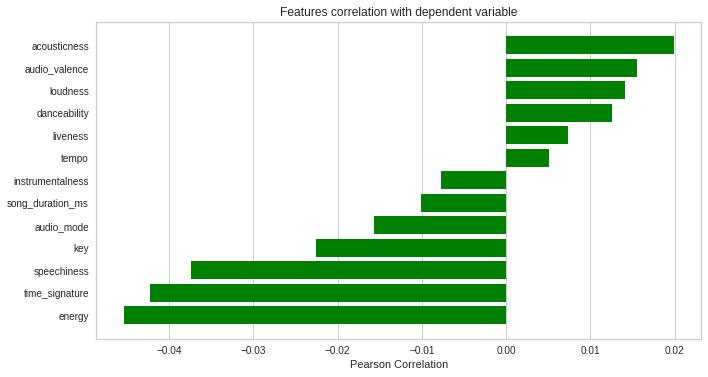

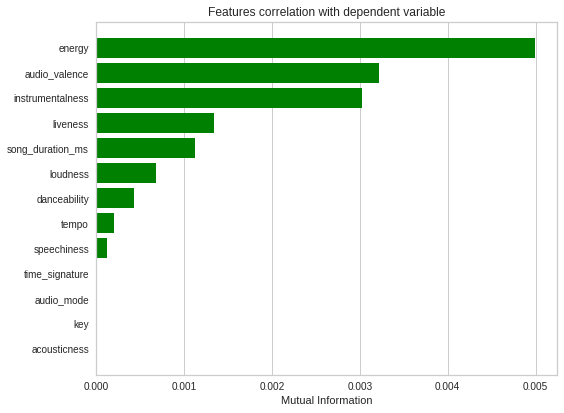

In [ ]:
#@title Pearson corelation and mutual information { display-mode: "form" }
song = songdata.drop("song_popularity", axis=1) # drop labels for training set
song_labels = songdata["song_popularity"].copy() 
song_test = songtest.drop("song_popularity", axis=1) # drop labels for test set
song_test_labels = songtest["song_popularity"].copy()
print(song.shape, song_labels.shape, song_test.shape, song_test_labels.shape)

from yellowbrick.target import FeatureCorrelation
plt.figure(figsize=(10, 5))
featurelist=['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence', 'key', 'audio_mode', 'time_signature']
features = np.array(featurelist)
visualizer = FeatureCorrelation(labels=features, color='Green', sort=True)
visualizer.fit(song, song_labels)
plt.savefig('pearson_correlation.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
visualizer.show()

visualizer = FeatureCorrelation(labels=features, color='Green',method='mutual_info-classification', sort=True)
visualizer.fit(song, song_labels, random_state=42)
plt.savefig('Mutual_Information.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
visualizer.show()

In [ ]:
#@title Metric function { display-mode: "form" }
def getAccuracy(y_test, y_pred):
  report = classification_report(y_test, y_pred)
  print("Classification report-->\n", report)
  cm = confusion_matrix(y_test, y_pred)
  conf_matrix_show(cm)
  tp, fn, fp, tn = cm.reshape(-1)
  print('Confusion matrix-->', 'tp=', tp, 'fn=', fn, 'fp=', fp, 'tn=', tn)
  acc_score = accuracy_score(y_test, y_pred)
  print("Accuracy score-->", acc_score)
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  print("AUC --> ", metrics.auc(fpr, tpr))

# Function to create a confusion matrix 
def conf_matrix_show(con_mat):    
    # Creating a confusion matrix
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

In [ ]:
#@title Prepare data by KNN imputing, scaling and applying OHE on cat columns { display-mode: "form" }
def prepare_data(train, test, categorical_col, numerical_col, numneighbours):
  """ Preprocessing the data"""
  #Function takes input the creditcard_dataset and the list of the names of categorical columns and numerical columns, and 
  #returns the array of predictor and target variables by applying one-hot encoding and feature scaling
  train.drop(columns=['id'], axis=1, inplace=True)
  test.drop(columns=['id'], axis=1, inplace=True)
  onehotencoder = OneHotEncoder(handle_unknown = 'ignore')
  scaler = StandardScaler()
  imputer = KNNImputer(n_neighbors=numneighbours)

  X_train = np.array([]); y_train = np.array([]); X_test = np.array([]); y_test = np.array([]);

  X = train.drop(['song_popularity'], axis=1)
  y_train = train['song_popularity']

  # Do not touch test data
  X_t = test.drop(['song_popularity'], axis=1)
  y_test = test['song_popularity']

  num_pipeline = Pipeline([('imputer', imputer),
                          ('scaler',scaler)
                          ])

  cat_pipeline = Pipeline([('imputer', imputer),
                          ('encoder',onehotencoder)
                          ])

  full_pipeline = ColumnTransformer([
                                    ('num',num_pipeline, numerical_col),
                                    ('cat',cat_pipeline,categorical_col)
                                    ])
  
  X_train = full_pipeline.fit_transform(X)
  X_test = full_pipeline.transform(X_t)
  ###############################
  return X_train, y_train, X_test, y_test

In [ ]:
#@title Prepare data by KNN imputing, scaling, power transformation, functional transformation and applying OHE on cat columns { display-mode: "form" }
def prepare_data_2(train, test, numneighbours):
  """ Preprocessing the data"""
  #Function takes input the creditcard_dataset and the list of the names of categorical columns and numerical columns, and 
  #returns the array of predictor and target variables by applying one-hot encoding and feature scaling
  train.drop(columns=['id'], axis=1, inplace=True)
  test.drop(columns=['id'], axis=1, inplace=True)
  onehotencoder = OneHotEncoder(handle_unknown = 'ignore')
  scaler = StandardScaler()
  imputer = KNNImputer(n_neighbors=numneighbours)

  X_train = np.array([]); y_train = np.array([]); X_test = np.array([]); y_test = np.array([]);

  X = train.drop(['song_popularity'], axis=1)
  y_train = train['song_popularity']

  # Do not touch test data
  X_t = test.drop(['song_popularity'], axis=1)
  y_test = test['song_popularity']

  num_pipeline = Pipeline([('imputer', imputer),
                          ('scaler',StandardScaler()),
                          #('pca', PCA(n_components=7)),
                          ])

  cat_pipeline = Pipeline([('imputer', imputer),
                          ('encoder',OneHotEncoder())
                          ])
  power_pipeline = Pipeline([
                          ('imputer', imputer),
                          ('power',PowerTransformer(method='yeo-johnson'))
                          ])
  fun_pipeline= Pipeline([
                          ('imputer', imputer),
                          ('func',FunctionTransformer(lambda x: np.log1p(-x)))
                          ])
  #numerical_col=['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']
  #numerical_col=['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness']
  numerical_col=['acousticness', 'danceability', 'energy', 'instrumentalness','liveness', 'speechiness', 'audio_valence']
  power_col = ['song_duration_ms', 'tempo']
  categorical_col=['key', 'audio_mode', 'time_signature']
  func_col=['loudness']
  full_pipeline = ColumnTransformer([
                                    ('num',num_pipeline,numerical_col),
                                    ('cat',cat_pipeline,categorical_col),
                                    ('pow',power_pipeline,power_col),
                                    ('func',fun_pipeline,func_col)
                                    ])
  X_train = full_pipeline.fit_transform(X)
  X_test = full_pipeline.transform(X_t)
  ###############################
  return X_train, y_train, X_test, y_test

In [ ]:
#@title Get Raw data { display-mode: "form" }
def getRawData():
  train_path = '/content/drive/Shareddrives/DA224-O/mp_2/data/team3_train.csv'
  test_path = '/content/drive/Shareddrives/DA224-O/mp_2/data/team3_test.csv'

  train = pd.read_csv(train_path)
  test = pd.read_csv(test_path)

  train.drop(columns=['id'], axis=1, inplace=True)
  test.drop(columns=['id'], axis=1, inplace=True)
  
  X_train = train.drop(['song_popularity'], axis=1)
  y_train = train['song_popularity']
  
  # Do not touch test data
  X_test = test.drop(['song_popularity'], axis=1)
  y_test = test['song_popularity']
  
  return X_train, y_train, X_test, y_test

In [ ]:
#@title Pre-Process data by passing through pipeline { display-mode: "form" }
#train, test = train_test_split(df, test_size=0.2, random_state=100)
#train, test = stratified_sampling(df)
def preprocess_data(param=True):
  train_path = '/content/drive/Shareddrives/DA224-O/mp_2/data/team3_train.csv'
  test_path = '/content/drive/Shareddrives/DA224-O/mp_2/data/team3_test.csv'
  mainDF_train = pd.read_csv(train_path)
  mainDF_test = pd.read_csv(test_path)
  categorical_col = ['key', 'audio_mode', 'time_signature',]
  numerical_col = ['song_duration_ms', 'acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',  'audio_valence']
  if (param):
    X_train, y_train, X_test, y_test = prepare_data(mainDF_train, mainDF_test, categorical_col, numerical_col, 3)
  else:
    X_train, y_train, X_test, y_test = prepare_data_2(mainDF_train, mainDF_test, 3)
  return X_train, y_train, X_test, y_test

In [ ]:
#@title Generic function for gridsearch and cross validation on various models { display-mode: "form" }
def gridsearch_run(model, param_grid, scoring='f1', nsplits=5, param=True):
  X_train, y_train, X_test, y_test = preprocess_data(param)
  grid_model = GridSearchCV(model, param_grid, scoring=scoring, cv=KFold(n_splits=nsplits,random_state=42,shuffle=True), n_jobs=-1)
  grid_model.fit(X_train, y_train)
  print(grid_model.best_params_)
  y_pred = grid_model.predict(X_test)
  y_pred_prob = grid_model.predict_proba(X_test)
  getAccuracy(y_test, y_pred)

{'C': 100}
Classification report-->
               precision    recall  f1-score   support

           0       0.63      1.00      0.77      3795
           1       0.50      0.00      0.01      2205

    accuracy                           0.63      6000
   macro avg       0.57      0.50      0.39      6000
weighted avg       0.58      0.63      0.49      6000

Confusion matrix--> tp= 3784 fn= 11 fp= 2194 tn= 11
Accuracy score--> 0.6325
AUC -->  0.5010450557034409


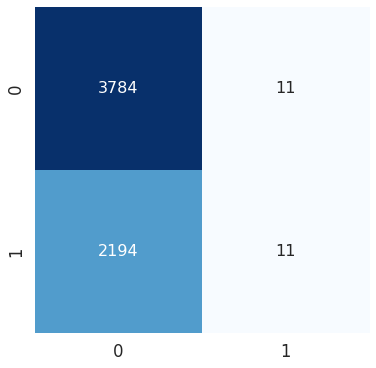

In [ ]:
#@title Logistic regression { display-mode: "form" }
model = LogisticRegression(random_state = 42, solver="newton-cg", penalty='l2')
param_grid = {'C': [0.001,0.01,0.1,1,10,100,1000]}
gridsearch_run(model, param_grid)

{'n_neighbors': 13}
Classification report-->
               precision    recall  f1-score   support

           0       0.64      0.85      0.73      3795
           1       0.42      0.19      0.26      2205

    accuracy                           0.61      6000
   macro avg       0.53      0.52      0.50      6000
weighted avg       0.56      0.61      0.56      6000

Confusion matrix--> tp= 3223 fn= 572 fp= 1789 tn= 416
Accuracy score--> 0.6065
AUC -->  0.5189687469190576


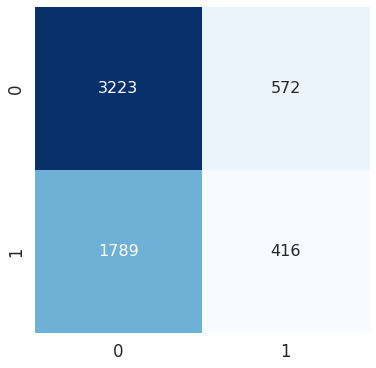

In [ ]:
#@title KneighboursClassifier { display-mode: "form" }
kn_clf = KNeighborsClassifier()
rangeval = np.arange(1, 15)
param_grid = dict(n_neighbors=rangeval)
gridsearch_run(kn_clf, param_grid, scoring='roc_auc', param=False)

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Classification report-->
               precision    recall  f1-score   support

           0       0.63      0.99      0.77      3795
           1       0.43      0.02      0.03      2205

    accuracy                           0.63      6000
   macro avg       0.53      0.50      0.40      6000
weighted avg       0.56      0.63      0.50      6000

Confusion matrix--> tp= 3746 fn= 49 fp= 2168 tn= 37
Accuracy score--> 0.6305
AUC -->  0.5019341596981348


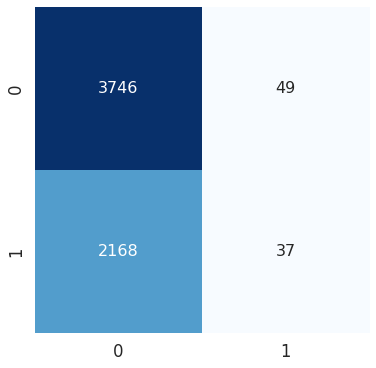

In [ ]:
#@title DecisionTreeClassifier { display-mode: "form" }
model = DecisionTreeClassifier(random_state=42)
param_grid = {"splitter":["best", "random"],
              "max_features":["log2", 2, 3, 4, 5, 6],
              "max_depth": [2, 3, 4, 5, 6],
              "min_samples_leaf": [1, 2, 3],
              "min_samples_split": [2, 3, 4, 5]}
gridsearch_run(model, param_grid)

{'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 80}
Classification report-->
               precision    recall  f1-score   support

           0       0.66      0.57      0.61      3795
           1       0.40      0.49      0.44      2205

    accuracy                           0.54      6000
   macro avg       0.53      0.53      0.53      6000
weighted avg       0.56      0.54      0.55      6000

Confusion matrix--> tp= 2162 fn= 1633 fp= 1117 tn= 1088
Accuracy score--> 0.5416666666666666
AUC -->  0.5315605029890744


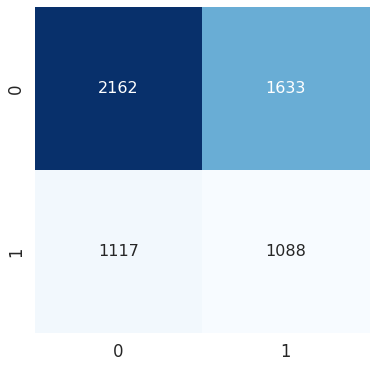

In [ ]:
#@title RandomForestClassfier { display-mode: "form" }
model = RandomForestClassifier(random_state=42,oob_score=True,n_jobs = -1)
param_grid = {"max_depth" : [20,30],
              "min_samples_leaf": [40,50,80],
              "max_features": ["log2", 5, 6,8],
              "class_weight" : ["balanced","balanced_subsample",None]}
gridsearch_run(model, param_grid)

{'class_weight': 'balanced', 'max_depth': 30, 'max_features': 8, 'min_samples_leaf': 80}
Classification report-->
               precision    recall  f1-score   support

           0       0.66      0.55      0.60      3795
           1       0.40      0.51      0.45      2205

    accuracy                           0.54      6000
   macro avg       0.53      0.53      0.52      6000
weighted avg       0.56      0.54      0.54      6000

Confusion matrix--> tp= 2099 fn= 1696 fp= 1087 tn= 1118
Accuracy score--> 0.5361666666666667
AUC -->  0.5300628288205927


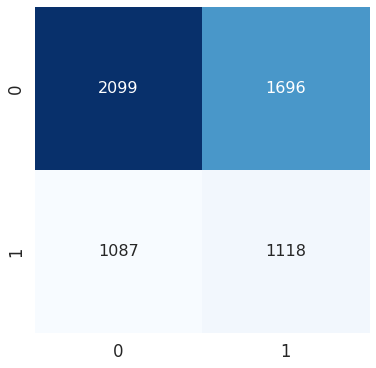

In [ ]:
#@title ExtraTreesClassifier { display-mode: "form" }
model = ExtraTreesClassifier(random_state=42, n_jobs = -1)
param_grid = {"max_depth" : [20,30],
              "min_samples_leaf": [40,50,80],
              "max_features": ["log2", 5, 6,8],
              "class_weight" : ["balanced","balanced_subsample",None]}
gridsearch_run(model, param_grid)

In [ ]:
#@title GridSearch for Catboost { display-mode: "form" }
def CatBoost_gridsearch_run(param_grid, scoring='f1',nsplits=5, param=True):
  X_train, y_train, X_test, y_test = preprocess_data(param)
  train_dataset = cb.Pool(X_train, y_train) 
  test_dataset = cb.Pool(X_test, y_test)
  grid_model = cb.CatBoostClassifier(objective='CrossEntropy')
  grid_model.grid_search(param_grid, train_dataset, cv=nsplits)
  y_pred = grid_model.predict(test_dataset)
  getAccuracy(y_test, y_pred)

Streaming output truncated to the last 5000 lines.
114:	learn: 0.3730245	test: 0.6745015	best: 0.6464390 (22)	total: 6.27s	remaining: 10.1s
115:	learn: 0.3715477	test: 0.6752009	best: 0.6464390 (22)	total: 6.32s	remaining: 10s
116:	learn: 0.3694850	test: 0.6760689	best: 0.6464390 (22)	total: 6.36s	remaining: 9.95s
117:	learn: 0.3680335	test: 0.6763225	best: 0.6464390 (22)	total: 6.42s	remaining: 9.9s
118:	learn: 0.3671347	test: 0.6762708	best: 0.6464390 (22)	total: 6.49s	remaining: 9.86s
119:	learn: 0.3660199	test: 0.6765159	best: 0.6464390 (22)	total: 6.54s	remaining: 9.81s
120:	learn: 0.3646452	test: 0.6769389	best: 0.6464390 (22)	total: 6.59s	remaining: 9.74s
121:	learn: 0.3636641	test: 0.6767974	best: 0.6464390 (22)	total: 6.63s	remaining: 9.68s
122:	learn: 0.3616526	test: 0.6773559	best: 0.6464390 (22)	total: 6.69s	remaining: 9.63s
123:	learn: 0.3599026	test: 0.6775823	best: 0.6464390 (22)	total: 6.75s	remaining: 9.58s
124:	learn: 0.3585463	test: 0.6775654	best: 0.6464390 (22)	tot

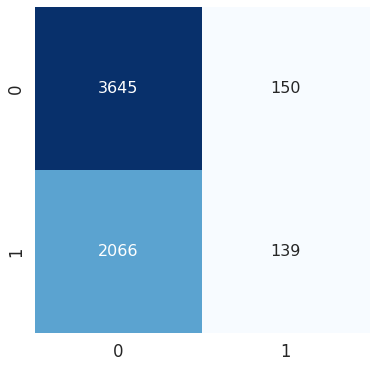

In [ ]:
#@title CatBoost { display-mode: "form" }
param_grid = {'iterations': [100, 150, 200,300],
        'learning_rate': [0.03, 0.1,0.25,0.5],
        'depth': [2, 4, 6, 8,10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
CatBoost_gridsearch_run(param_grid, nsplits=5)

{'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 10, 'learning_rate': 0.1, 'n_estimators': 50}
Classification report-->
               precision    recall  f1-score   support

           0       0.64      0.84      0.72      3795
           1       0.39      0.18      0.25      2205

    accuracy                           0.60      6000
   macro avg       0.52      0.51      0.49      6000
weighted avg       0.55      0.60      0.55      6000

Confusion matrix--> tp= 3174 fn= 621 fp= 1803 tn= 402
Accuracy score--> 0.596
AUC -->  0.5093382807668523


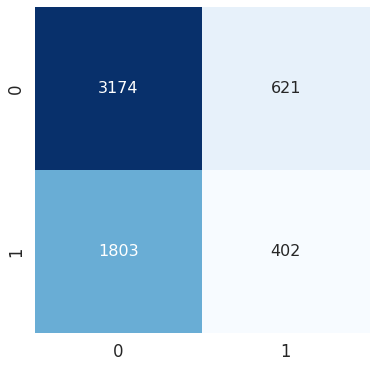

In [ ]:
#@title AdaBoostClassifier { display-mode: "form" }
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

param_grid = {'base_estimator__max_depth':[3, 5, 10],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50],
              'learning_rate':[0.01,0.1]}

gridsearch_run(model, param_grid)

{'booster': 'gbtree', 'eval_metric': 'logloss', 'max_depth': 30, 'n_estimators': 10, 'tree_method': 'hist'}
Classification report-->
               precision    recall  f1-score   support

           0       0.64      0.80      0.71      3795
           1       0.40      0.23      0.29      2205

    accuracy                           0.59      6000
   macro avg       0.52      0.52      0.50      6000
weighted avg       0.55      0.59      0.56      6000

Confusion matrix--> tp= 3045 fn= 750 fp= 1701 tn= 504
Accuracy score--> 0.5915
AUC -->  0.5154714850367025


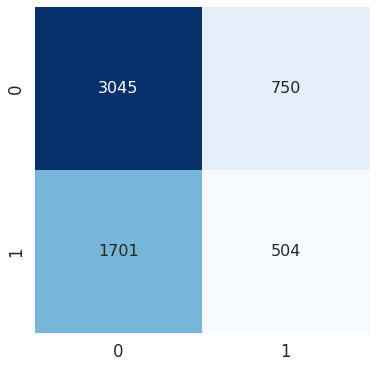

In [ ]:
#@title XGBClassifier { display-mode: "form" }

model = xgb.XGBClassifier()
param_grid = {
    'n_estimators' : [10, 30, 100],
    'booster' : ['gbtree', 'gblinear'],
    'tree_method' : ['approx', 'hist'],
    'max_depth' : [10, 30],
    'eval_metric' : ['logloss', 'error']
}

gridsearch_run(model, param_grid)

In [ ]:
#@title SVC RBF Kernel { display-mode: "form" }

model = SVC()
param_grid = {
    "probability": [True],
    "kernel": ["rbf"],
    "gamma": ['scale', 'auto', 0.5, 5, 10],
    "C": [0.1, 1, 10]
}

gridsearch_run(model, param_grid)

In [ ]:
#@title SVC Poly Kernel { display-mode: "form" }

model = SVC()
param_grid = {
    "probability": [True],
    "kernel": ["poly"],
    "degree": [2, 3, 4],
    "C": [0.1, 1, 10]
}

gridsearch_run(model, param_grid)

In [ ]:
#@title SVC Linear Kernel { display-mode: "form" }

model = SVC()
param_grid = {
    "probability": [True],
    "kernel": ["linear"],
    "gamma": ['scale', 'auto', 0.5, 5, 10],
    "C": [0.1, 1, 10]
}

gridsearch_run(model, param_grid)

Device used : cpu
epoch 0  | loss: 0.70611 | train_auc: 0.53773 | train_accuracy: 0.54046 |  0:00:03s
epoch 1  | loss: 0.69368 | train_auc: 0.53992 | train_accuracy: 0.44221 |  0:00:07s
epoch 2  | loss: 0.69001 | train_auc: 0.55062 | train_accuracy: 0.48667 |  0:00:10s
epoch 3  | loss: 0.69    | train_auc: 0.55587 | train_accuracy: 0.5475  |  0:00:14s
epoch 4  | loss: 0.69004 | train_auc: 0.55688 | train_accuracy: 0.49204 |  0:00:17s
epoch 5  | loss: 0.68871 | train_auc: 0.55747 | train_accuracy: 0.50967 |  0:00:21s
epoch 6  | loss: 0.68952 | train_auc: 0.56079 | train_accuracy: 0.51262 |  0:00:24s
epoch 7  | loss: 0.68805 | train_auc: 0.56274 | train_accuracy: 0.53775 |  0:00:28s
epoch 8  | loss: 0.68744 | train_auc: 0.56717 | train_accuracy: 0.51113 |  0:00:31s
epoch 9  | loss: 0.68799 | train_auc: 0.56315 | train_accuracy: 0.51488 |  0:00:34s
epoch 10 | loss: 0.68837 | train_auc: 0.57228 | train_accuracy: 0.53188 |  0:00:38s
epoch 11 | loss: 0.68677 | train_auc: 0.57061 | train_accu

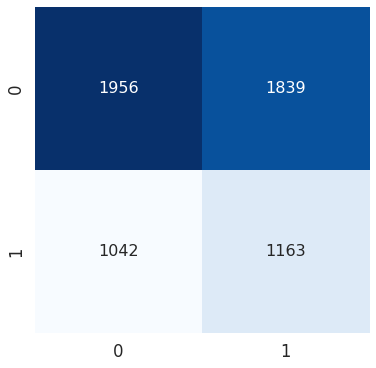

In [ ]:
#@title TabNet using PyTorch { display-mode: "form" }

X_train, y_train, X_test, y_test = preprocess_data()

# define the model
clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model 
clf1_nopreproc.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train)],
    eval_name=['train'],
    eval_metric=['auc','accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)
y_pred = clf1_nopreproc.predict(X_test)
getAccuracy(y_test, y_pred)

oobe_score------> 0.6363333333333333
oobe_dec_func---->
 [[0.56370235 0.43629765]
 [0.63603967 0.36396033]
 [0.64931899 0.35068101]
 ...
 [0.61000083 0.38999917]
 [0.67775095 0.32224905]
 [0.57745594 0.42254406]]
Classification report-->
               precision    recall  f1-score   support

           0       0.63      1.00      0.77      3795
           1       0.00      0.00      0.00      2205

    accuracy                           0.63      6000
   macro avg       0.32      0.50      0.39      6000
weighted avg       0.40      0.63      0.49      6000

Confusion matrix--> tp= 3795 fn= 0 fp= 2205 tn= 0
Accuracy score--> 0.6325
AUC -->  0.5


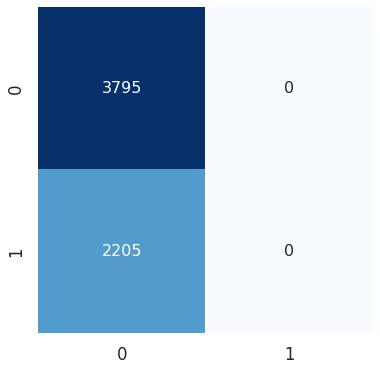

In [ ]:
#@title BaggingClassifier with oobe=True and best params for DT  { display-mode: "form" }
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_leaf=1, min_samples_split=2, splitter='best'), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True) #bagging
X_train, y_train, X_test, y_test = preprocess_data()
bag_clf.fit(X_train, y_train)
print("oobe_score------>", bag_clf.oob_score_)
print("oobe_dec_func---->\n", bag_clf.oob_decision_function_)
y_pred = bag_clf.predict(X_test)
getAccuracy(y_test, y_pred)

Classification report-->
               precision    recall  f1-score   support

           0       0.63      1.00      0.77      3795
           1       0.41      0.00      0.01      2205

    accuracy                           0.63      6000
   macro avg       0.52      0.50      0.39      6000
weighted avg       0.55      0.63      0.49      6000

Confusion matrix--> tp= 3782 fn= 13 fp= 2196 tn= 9
Accuracy score--> 0.6318333333333334
AUC -->  0.5003280363528811


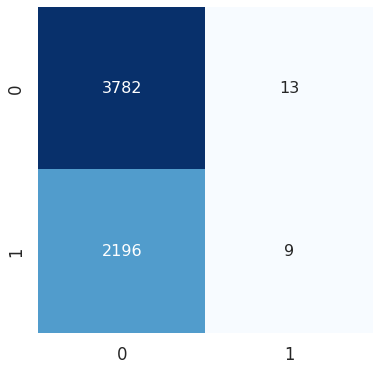

In [ ]:
#@title BaggingClassifier(pasting) and best params for DT { display-mode: "form" }
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_leaf=1, min_samples_split=2, splitter='best'), n_estimators=500, max_samples=100, bootstrap=False, n_jobs=-1)#pasting
X_train, y_train, X_test, y_test = preprocess_data()
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
getAccuracy(y_test, y_pred)

In [ ]:
#@title Hardvoting classfier with LR, RF, ET, ADA, GB { display-mode: "form" }
#hard voting classifier
from sklearn.ensemble import GradientBoostingClassifier
log_clf = LogisticRegression(random_state = 42, C=100, solver="newton-cg")
rnd_clf = RandomForestClassifier(random_state = 42, class_weight='balanced_subsample', max_depth=30, max_features=6, min_samples_leaf=80)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10), random_state = 42, learning_rate=0.1, n_estimators=50)
gdb = GradientBoostingClassifier(random_state = 42, learning_rate=0.8, n_estimators=64)
etc = ExtraTreesClassifier(random_state = 42, class_weight='balanced_subsample', max_depth=30, max_features=6, min_samples_leaf=80)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('ada', ada), ('gdb', gdb), ('etc', etc)], voting='hard')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
getAccuracy(y_test, y_pred)

Classification report-->
               precision    recall  f1-score   support

           0       0.64      0.93      0.76      3795
           1       0.45      0.10      0.17      2205

    accuracy                           0.62      6000
   macro avg       0.54      0.51      0.46      6000
weighted avg       0.57      0.62      0.54      6000

Confusion matrix--> tp= 3511 fn= 284 fp= 1977 tn= 228
Accuracy score--> 0.6231666666666666
AUC -->  0.5142830254631497


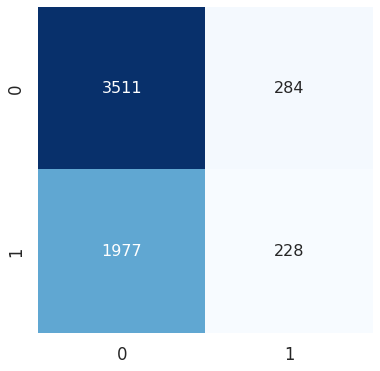

In [ ]:
#@title Softvoting classifier with LR, RF, ET, ADA, GB { display-mode: "form" }
#soft voting classifier
from sklearn.ensemble import GradientBoostingClassifier
log_clf = LogisticRegression(random_state = 42, C=100, solver="newton-cg")
rnd_clf = RandomForestClassifier(random_state = 42, class_weight='balanced_subsample', max_depth=30, max_features=6, min_samples_leaf=80)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10), random_state = 42, learning_rate=0.1, n_estimators=50)
gdb = GradientBoostingClassifier(random_state = 42, learning_rate=0.8, n_estimators=64)
etc = ExtraTreesClassifier(random_state = 42, class_weight='balanced_subsample', max_depth=30, max_features=6, min_samples_leaf=80)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('ada', ada), ('gdb', gdb), ('etc', etc)], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
getAccuracy(y_test, y_pred)

In [ ]:
#@title Voting CLassifier with (RandomForestClassifier, SVC, KNeighborsClassifier, GaussianNB, CatBoostClassifier, CatBoostClassifier and XGBClassifier)
from catboost.core import CatBoostClassifier
from xgboost import XGBClassifier
def evaluateCVModel(X_train, y_train, X_test, y_test):
  # model = modelPipeline[0]
  # pipeline = modelPipeline[1]
  #soft voting classifier
  # log_clf = LogisticRegression(
  #                               solver ='lbfgs',
  #                              penalty = 'l2',
  #                               multi_class ='auto',
  #                              warm_start=False,
  #                               max_iter = 100, 
  #                              random_state=42, 
  #                             n_jobs=-1
  #                             )
  rnd_clf = RandomForestClassifier(
                                oob_score=True, 
                                warm_start=True, # from GridSearchCV
                                criterion='gini', # from GridSearchCV
                                n_estimators=100, # from GridSearchCV
                                max_depth=50, # from GridSearchCV
                                random_state=42
                            )
  svm_clf = SVC(
                C=0.75, # from GridSearchCV
                probability=True, 
                max_iter= 500, # from GridSearchCV
                random_state=42
                )
  knn_clf = KNeighborsClassifier(
                                n_neighbors=2,
                                weights='distance',
                                leaf_size=10,
                                n_jobs=-1
                                )
  gaus_clf = GaussianNB(
    var_smoothing=1e-11
    )
  cat_clf = CatBoostClassifier(
                        iterations=500,# from GridSearchCV
                        learning_rate=0.95,
                        depth=5, # from GridSearchCV
                        random_state=42)
  bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter='best'), 
                            # n_estimators=100, 
                            n_estimators=500, # from GridSearchCV
                            bootstrap=False,  # from GridSearchCV
                            n_jobs=-1)
  xg_clf = XGBClassifier(
                    order='F',
                    n_estimators=15,
                    random_state=42,
                    max_depth=10,
                    gamma=0.2,
                    learning_rate=0.9,
                   n_jobs=-1
                  )

  voting_clf = VotingClassifier(estimators=[
                                            # ('lr', log_clf), 
                                            ('rf', rnd_clf), 
                                            ('svc', svm_clf),
                                            ('gaus', gaus_clf),
                                            ('knn', knn_clf),
                                            ('cat', cat_clf),
                                            ('xgb', xg_clf),
                                            ('bag', bag_clf),
                                          ],
                                voting='soft', 
                                n_jobs=-1
                                # random_state=42
                              )
  voting_clf.fit(X_train, y_train)
  y_pred = voting_clf.predict(X_test)
  # acc_score = accuracy_score(y_test, y_pred)
  # print(acc_score)
  # cm = confusion_matrix(y_test, y_pred)   
  # tp, fn, fp, tn = cm.reshape(-1)
  # print('tp=', tp, 'fn=', fn, 'fp=', fp, 'tn=', tn)


  # RMSE = mean_squared_error(y1, y_test_predict, squared=False)
  # R2 = r2_score(y1, y_test_predict, multioutput='variance_weighted')
  # printmd("**Model : "+type(model).__name__+",  RMSE = " +str(RMSE)+ ", R2 ="+ str(R2) + "**")

  return y_pred, y_test, voting_clf
  
param = False
X_train_votg, y_train_votg, X_test_votg, y_test_votg = preprocess_data(param)
y_pred_voting, y_test_voting, voting_clf = evaluateCVModel(X_train_votg, y_train_votg, X_test_votg, y_test_votg)
getAccuracy(y_test_voting, y_pred_voting)

In [ ]:
#@title Stratified spliting for LightGBM { display-mode: "form" }
N_SPLITS = 5
col_y = 'song_popularity'

X = df.copy()
y = X.pop(col_y)

col_cat = ['key', 'audio_mode', 'time_signature']
col_num = X.drop(columns=col_cat).columns
missing_ind = impute.MissingIndicator(features='missing-only')
missing_values = missing_ind.fit_transform(X)

missing_values = pd.DataFrame(missing_values, index=X.index)


# all categorical except `key` because it contains too many classes
# (split of less than 1 combination)
col_strat = [col_y, 'audio_mode', 'time_signature']

strat, _ = (
    df[['audio_mode', 'time_signature', col_y]]
    .join(missing_values.any(axis=1).rename('missing'))
    .astype('str')
    .apply(lambda row: '_'.join(row), axis=1)
    .factorize()
)
strat = pd.Series(strat, index=df.index)


# Split dev/test
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.1, random_state=random_state, shuffle=True, stratify=strat)

dev_index = X.index.isin(X_dev.index).astype(int)
test_split = PredefinedSplit(dev_index)

strat_dev = strat.loc[X_dev.index]
strat_test = strat.loc[X_test.index]


# Split train/valid
def make_folds(X, strat):
    strat_folds = StratifiedKFold(n_splits=N_SPLITS,
                                  shuffle=True,
                                  random_state=random_state)

    cv_fold = np.empty([len(X), 1], dtype=np.int32)

    for i, (_, test_index) in enumerate(strat_folds.split(X, strat)):
        cv_fold[test_index] = i

    return PredefinedSplit(cv_fold)
    
cv_split = make_folds(X_dev, strat_dev)
full_split = make_folds(X, strat)

In [ ]:
#@title LightGBM with KNN imputation { display-mode: "form" }

random_state = 42
col_sig = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'audio_valence',
]
col_pow = [ 'song_duration_ms', 'tempo']

# Model Pipeline


pipe = Pipeline([
    ('imputer',impute.KNNImputer(n_neighbors=2)),
    ('model', LogisticRegression())
])

param_grid = [{
    'model': [LGBMClassifier()],
    'imputer': [impute.KNNImputer(n_neighbors=2)],
    
}]

#gridsearch_run(pipe, param_grid, scoring=['roc_auc', 'neg_log_loss'])

grid_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=['roc_auc', 'neg_log_loss'],
    n_jobs=4,
    refit='roc_auc',
    cv=cv_split,
    verbose=1,
    error_score='raise',
    return_train_score=True
)

#X_train, y_train, X_test, y_test = getRawData()

grid_model.fit(X_dev, y_dev)
print(grid_model.best_params_)
y_pred = grid_model.predict(X_test)
y_pred_prob = grid_model.predict_proba(X_test)
getAccuracy(y_test, y_pred)

In [ ]:
#@title LightGBM with Iterative imputation { display-mode: "form" }

random_state = 42
col_sig = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'audio_valence',
]
col_pow = [ 'song_duration_ms', 'tempo']

# Model Pipeline


pipe = Pipeline([
    ('imputer',impute.KNNImputer(n_neighbors=2)),
    ('model', LogisticRegression())
])

param_grid = [{
    'model': [LGBMClassifier()],
    'imputer': [impute.IterativeImputer(random_state=random_state)],
    
}]

#gridsearch_run(pipe, param_grid, scoring=['roc_auc', 'neg_log_loss'])

grid_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=['roc_auc', 'neg_log_loss'],
    n_jobs=4,
    refit='roc_auc',
    cv=cv_split,
    verbose=1,
    error_score='raise',
    return_train_score=True
)

#X_train, y_train, X_test, y_test = getRawData()

grid_model.fit(X_dev, y_dev)
print(grid_model.best_params_)
y_pred = grid_model.predict(X_test)
y_pred_prob = grid_model.predict_proba(X_test)
getAccuracy(y_test, y_pred)

In [ ]:
#@title Online inspired code { display-mode: "form" }
#Challenge Winner's code
random_state = 42
col_sig = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'audio_valence',
]
col_pow = [ 'song_duration_ms', 'tempo']

# Model Pipeline
inv_sigmoid = Pipeline([
    ('0', preprocessing.MinMaxScaler(feature_range=(1e-3, 1-1e-3))),
    ('1', FunctionTransformer(lambda x: np.log(x / (1-x)))),
    ('2', preprocessing.PowerTransformer())
])

transformer = ColumnTransformer([
    ('inv_sigmoid', inv_sigmoid, col_sig),
    ('scale', preprocessing.PowerTransformer(), col_pow),
    ('db_to_num', FunctionTransformer(lambda x: np.log1p(-x)), ['loudness']),
], remainder='passthrough')

pipe = Pipeline([
    ('transform', transformer),
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('model', LogisticRegression())
])

param_grid = [{
    'model': [LogisticRegression(),
              HistGradientBoostingClassifier(),
              LGBMClassifier(),
              ExtraTreesClassifier()],
    'imputer': [impute.SimpleImputer(strategy='median'),
                impute.SimpleImputer(strategy='mean'),
               ],#impute.KNNImputer()],
    'transform__inv_sigmoid__0': ['passthrough'],
    'transform__inv_sigmoid__1': ['passthrough'],
},{
    'model': [LogisticRegression(),
              HistGradientBoostingClassifier(),
              LGBMClassifier(),
              ExtraTreesClassifier()],
    'imputer': [impute.SimpleImputer(strategy='median'),
                impute.SimpleImputer(strategy='mean'),
                ],#impute.KNNImputer()],
},{
    'model': [HistGradientBoostingClassifier(), LGBMClassifier()],
    'imputer': ['passthrough',
                impute.IterativeImputer(random_state=random_state),
                impute.IterativeImputer(random_state=random_state, add_indicator=True)],
},{
    'model': [HistGradientBoostingClassifier(), LGBMClassifier()],
    'imputer': ['passthrough'],
    'transform__inv_sigmoid__0': ['passthrough'],
    'transform__inv_sigmoid__1': ['passthrough'],
}]

#gridsearch_run(pipe, param_grid, scoring=['roc_auc', 'neg_log_loss'])

grid_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=['roc_auc', 'neg_log_loss'],
    n_jobs=4,
    refit='roc_auc',
    cv=5,
    verbose=1,
    error_score='raise',
    return_train_score=True
)

X_train, y_train, X_test, y_test = getRawData()

grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
y_pred = grid_model.predict(X_test)
y_pred_prob = grid_model.predict_proba(X_test)
getAccuracy(y_test, y_pred)

In [ ]:
#@title Split Based Modelling { display-mode: "form" }
def getMask(df, feature):
  map_dict = {
      'instrumentalness': (df['instrumentalness'] <= 0.002),
      'liveness': ((df['liveness'] >= 0.1) & (df['liveness'] <= 0.2)),
      'audio_mode': (df['audio_mode'] == 1),
      'time_signature': (df['time_signature'] == 4)
  }
  return map_dict.get(feature)

def split_data(mask,X):
  dfWithClass = X[mask].copy()
  dfWithoutClass = X[~mask].copy()
  dfWithClass.reset_index(drop=True, inplace=True)
  dfWithoutClass.reset_index(drop=True, inplace=True)
  return dfWithClass,dfWithoutClass
def prepare_data_split(train, test, categorical_col, numerical_col, numneighbours, feature):
  """ Preprocessing the data"""
  #Function takes input the creditcard_dataset and the list of the names of categorical columns and numerical columns, and 
  #returns the array of predictor and target variables by applying one-hot encoding and feature scaling
  train.drop(columns=['id'], axis=1, inplace=True)
  test.drop(columns=['id'], axis=1, inplace=True)


  X_train = np.array([]); y_train = np.array([]); X_test = np.array([]); y_test = np.array([]); 


  mask_train = getMask(train,feature)
  mask_test = getMask(test,feature)
  #mask_pred = getMask(pred,feature)


  trainWithClass, trainWithoutClass = split_data(mask_train,train)
  testWithClass, testWithoutClass = split_data(mask_test,test)
  #predWithClass, predWithoutClass = split_data(mask_pred,pred)


  X_withClass = trainWithClass.drop(['song_popularity'], axis=1)
  y_train_withClass = trainWithClass['song_popularity']
  X_withoutClass = trainWithoutClass.drop(['song_popularity'], axis=1)
  y_train_withoutClass = trainWithoutClass['song_popularity']

  # Do not touch test data
  X_t_withClass = testWithClass.drop(['song_popularity'], axis=1)
  y_test_withClass = testWithClass['song_popularity']
  X_t_withoutClass = testWithoutClass.drop(['song_popularity'], axis=1)
  y_test_withoutClass = testWithoutClass['song_popularity']

  #X_pred_withClass = predWithClass.drop(['song_popularity'], axis=1)
  #y_pred_withClass = predWithClass['song_popularity']
  #X_pred_withoutClass = predWithoutClass.drop(['song_popularity'], axis=1)
  #y_pred_withoutClass = predWithoutClass['song_popularity']

  

  num_pipeline_withClass = Pipeline([('imputer', KNNImputer(n_neighbors=numneighbours)),('scaler',StandardScaler())])

  cat_pipeline_withClass = Pipeline([('imputer', KNNImputer(n_neighbors=numneighbours)),('encoder',OneHotEncoder(handle_unknown = 'ignore'))])

  full_pipeline_withClass = ColumnTransformer([('num',num_pipeline_withClass, numerical_col),('cat',cat_pipeline_withClass,categorical_col)])
  
  num_pipeline_withoutClass = Pipeline([('imputer', KNNImputer(n_neighbors=numneighbours)),('scaler',StandardScaler())])

  cat_pipeline_withoutClass = Pipeline([('imputer', KNNImputer(n_neighbors=numneighbours)),('encoder',OneHotEncoder(handle_unknown = 'ignore'))])

  full_pipeline_withoutClass = ColumnTransformer([('num',num_pipeline_withoutClass, numerical_col),('cat',cat_pipeline_withoutClass,categorical_col) ])
  
  X_train_withClass = full_pipeline_withClass.fit_transform(X_withClass)
  X_train_withoutClass = full_pipeline_withoutClass.fit_transform(X_withoutClass)

  X_test_withClass = full_pipeline_withClass.transform(X_t_withClass)
  X_test_withoutClass = full_pipeline_withoutClass.transform(X_t_withoutClass)

  #X_pred_withClass = full_pipeline_withClass.transform(X_pred_withClass)
  #X_pred_withoutClass = full_pipeline_withoutClass.transform(X_pred_withoutClass)
  ###############################
  return X_train_withClass,X_train_withoutClass, y_train_withClass,y_train_withoutClass, X_test_withClass,X_test_withoutClass, y_test_withClass, y_test_withoutClass#, X_pred_withClass, X_pred_withoutClass, y_pred_withClass, y_pred_withoutClass

#train, test = train_test_split(df, test_size=0.2, random_state=100)
#train, test = stratified_sampling(df)
def preprocess_data_split(feature, param=True):
  train_path = '/content/drive/Shareddrives/DA224-O/mp_2/data/team3_train.csv'
  test_path = '/content/drive/Shareddrives/DA224-O/mp_2/data/team3_test.csv'
  #pred_path  = "/content/drive/Shareddrives/DA224-O/mp_2/data/kaggle/test.csv"
  #pred_df2  = pd.read_csv(pred_path)

  #pred_df2['song_popularity'] = 0
  #print(pred_df2.info())
  mainDF_train = pd.read_csv(train_path, index_col=0)
  mainDF_test = pd.read_csv(test_path, index_col=0)
  categorical_col = ['key', 'audio_mode', 'time_signature',]
  numerical_col = ['song_duration_ms', 'acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',  'audio_valence']

  X_train_withClass, X_train_withoutClass, y_train_withClass, y_train_withoutClass, X_test_withClass, X_test_withoutClass, y_test_withClass, y_test_withoutClass = prepare_data_split(mainDF_train, mainDF_test, categorical_col, numerical_col, 3, feature)
  return X_train_withClass, X_train_withoutClass, y_train_withClass, y_train_withoutClass, X_test_withClass, X_test_withoutClass, y_test_withClass, y_test_withoutClass
def CatBoost_gridsearch_run_split(param_grid, feature, scoring='f1', nsplits=5, param=True):
  predicted = []
  ground_truth = []

  X_train_withClass, X_train_withoutClass, y_train_withClass, y_train_withoutClass, X_test_withClass, X_test_withoutClass, y_test_withClass, y_test_withoutClass = preprocess_data_split(feature, param)
  train_dataset_wc = cb.Pool(X_train_withClass, y_train_withClass)
  train_dataset_woc = cb.Pool(X_train_withoutClass, y_train_withoutClass)

  test_dataset_wc = cb.Pool(X_test_withClass, y_test_withClass)
  test_dataset_woc = cb.Pool(X_test_withoutClass, y_test_withoutClass)

  #pred_dataset_wc = cb.Pool(X_pred_withClass, y_pred_withClass)
  #pred_dataset_woc = cb.Pool(X_pred_withoutClass, y_pred_withoutClass)
  
  grid_model_wc = cb.CatBoostClassifier(objective='CrossEntropy', silent=True)
  grid_model_wc.grid_search(param_grid, train_dataset_wc)

  grid_model_woc = cb.CatBoostClassifier(objective='CrossEntropy', silent=True)
  grid_model_woc.grid_search(param_grid, train_dataset_woc)

  y_p_withClass = grid_model_wc.predict(X_test_withClass)
  predicted.extend(y_p_withClass)
  ground_truth.extend(y_test_withClass)

  y_p_withoutClass = grid_model_woc.predict(X_test_withoutClass)
  predicted.extend(y_p_withoutClass)
  ground_truth.extend(y_test_withoutClass)

  getAccuracy(ground_truth, predicted)

features = ['instrumentalness', 'liveness', 'audio_mode', 'time_signature']
for feature in features:
  print("Feature_Split: ", feature)
  param_grid = {'iterations': [100, 150, 200,300],
        'learning_rate': [0.03, 0.1,0.25,0.5],
        'depth': [2, 4, 6, 8,10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
  CatBoost_gridsearch_run_split(param_grid,feature,nsplits=5)